In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from empiricalgalo import utils, models

import joblib

%load_ext autoreload
%autoreload 2

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [41]:
data = np.load("../data/HAGNmatch.npy")

m = (data["H_level"] == 1) & (data["H_mhalo"] > 1e10) & (data["G_mgal"] > 1e9)
data = data[m]


features = ["H_mhalo", "H_concentration", "H_spin"]
log_features = ["H_mhalo", "H_concentration", "H_spin"]

target = "G_mgal"

In [42]:
Xtrain, Xtest, ytrain, ytest = utils.stratify_split(data, features, target, target, True)

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
features_pipe = Pipeline([('selector', utils.DataFrameSelector(features, log_features)),
                          ('PCA', PCA(whiten=True, n_components=len(features)))])
# features_pipe = Pipeline([('selector', utils.DataFrameSelector(features, log_features)),
                        #   ('scaler', StandardScaler())])
target_pipe = Pipeline([('selector', utils.DataFrameSelector(target, target))])

In [45]:
Xtrain, Xtest = utils.apply_preprocess(Xtrain, Xtest, features_pipe)
ytrain, ytest = utils.apply_preprocess(ytrain, ytest, target_pipe)

In [46]:
checkpoint_dir = "./checkpoints"
batch_size = 500


clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001,
    maximal_learning_rate=0.01,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * len(ytrain) // batch_size)
optimizer = tf.optimizers.Adamax(learning_rate=clr)

Nensemble = 24

In [47]:
cdirs = models.make_checkpoint_dirs(checkpoint_dir, Nensemble)
seeds = models.get_random_seeds(Nensemble, 42)

In [50]:
for i in range(Nensemble):
    models.GaussianLossNN.fit_directly(
        Xtrain, ytrain, batch_size, cdirs[i], seeds[i],
        optimizer=optimizer)

2022-05-08 23:45:34.198960: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-05-08 23:45:34.233253: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [167]:
ensemble = models.SummaryEnsembleGaussianLossNN(checkpoint_dir, optimizer)

Found 24 models in `./checkpoints`.


In [197]:
ensemble.check_convergence(Xtest, ytest)

[0.92644663 0.92807903 0.92798339 0.92809053 0.92606248 0.92282857
 0.92650674 0.9283144  0.92672166 0.92634143 0.92631222 0.92650875
 0.92825865 0.92788496 0.92482884 0.9276316  0.92878477 0.92924463
 0.92762479 0.92726159 0.92796813 0.92602481 0.92564252 0.92753774
 0.8       ]
len  25
Lower 0.8772615940338544
len  24
Lower 0.8773996673734653
1
0.00014890440895998225
0.9273996673734654 0.9273996673734654
len  24
Lower 0.8773996673734653
2
0.0
0.9273996673734654 0.9273996673734654
len  24
Lower 0.8773996673734653
3
0.0
0.9273996673734654 0.9273996673734654
len  24
Lower 0.8773996673734653
4
0.0
0.9273996673734654 0.9273996673734654


In [190]:
grads = ensemble.predict_gradient_summary(Xtest, True)

In [148]:
grads.shape

(2, 2, 9847, 3)

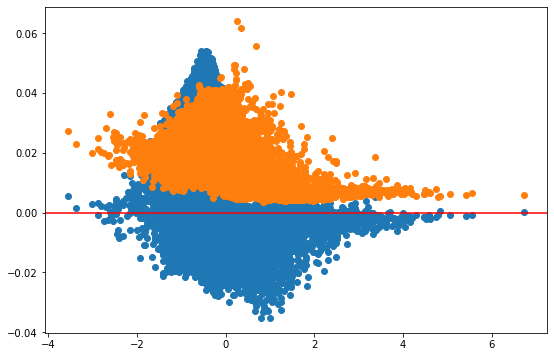

In [166]:
plt.figure(figsize=(9,6))
i = 0
plt.scatter(Xtest[:, i], grads[1, 0, :, i])
plt.scatter(Xtest[:, i], grads[1, 1, :, i])
plt.axhline(0, c='red')
plt.show()

In [66]:
R2s = ensemble.score_R2mean(Xtest, ytest)

In [67]:
chi2s = ensemble.score_reduced_chi2(Xtest, ytest)

In [78]:
pred = ensemble.predict_summary(Xtest, True, True)

In [82]:
R2s

[0.9264466267622952,
 0.9280790286076491,
 0.9279833875878161,
 0.9280905320510233,
 0.9260624810952038,
 0.9228285674656097,
 0.9265067440429781,
 0.9283143985433584,
 0.9267216591501622,
 0.9263414346395072,
 0.9263122213805225,
 0.926508745426148,
 0.9282586548708706,
 0.927884956403802,
 0.9248288390976562,
 0.927631598980306,
 0.92878476968871,
 0.9292446268634911,
 0.9276247858465407,
 0.9272615940338544,
 0.9279681251690268,
 0.9260248103998645,
 0.9256425224424498,
 0.9275377407130763]